In [1]:
%load_ext autoreload
%autoreload 2

from keras.models import Sequential, load_model
from keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import fbeta_score
from sklearn.externals import joblib

import numpy as np
import cPickle as pickle
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import os
import sys

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 950M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5005)


In [2]:
paths = ['../models', '../rainforest', '../scripts']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
        
import dataset
from data import *
from data_generators_leo import get_data

data_path = '..\\data\\'
jpg_path = data_path + 'train-jpg'
batch_size=8

weather_labels = ['clear', 'cloudy', 'haze', 'partly_cloudy']
train_csv = get_class_data(train=True, label='weather')
val_csv = get_class_data(train=False, label='weather')

train_labels = np.asarray(train_csv)[:,1:5]
train_data = np.asarray(train_csv)[:,0]
all_zeros_train = [index for index, label in enumerate(train_labels) if sum(label) == 0]
if(all_zeros_train > 0):
    train_data = np.delete(train_data, all_zeros_train)
    train_labels = np.delete(train_labels, all_zeros_train, axis=0)

val_labels = np.asarray(val_csv)[:,1:5]
val_data = np.asarray(val_csv)[:,0]
all_zeros_val = [index for index, label in enumerate(val_labels) if sum(label) == 0]
if(all_zeros_val > 0):
    val_data = np.delete(val_data, all_zeros_val)
    val_labels = np.delete(val_labels, all_zeros_val, axis=0)

print(train_labels.shape)
print(train_data.shape)
print(val_labels.shape)
print(val_data.shape)

(28334L, 4L)
(28334L,)
(12144L, 4L)
(12144L,)


In [3]:
#train_gen = get_data(train_data, '..\\data\\train-jpg', train_labels, 
                                      #flip=True, shift_x=5, shift_y=5, rot_range=10,
                                      #elastic_trans=False, batch_size=8, balance_batches=True)

train_gen = get_data(train_data, jpg_path, train_labels, augmentation=False,
                     batch_size=batch_size, img_size=(64, 64), balance_batches=True)
        
val_gen = get_data(val_data, jpg_path, val_labels, augmentation=False,
                   batch_size=batch_size, img_size=(64, 64), balance_batches=True)
 

(64L, 64L, 3L)
[1 0 0 0]
()


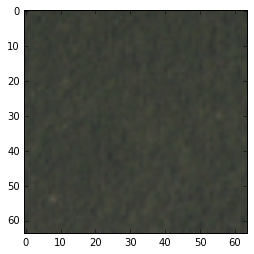

(64L, 64L, 3L)
[1 0 0 0]
()


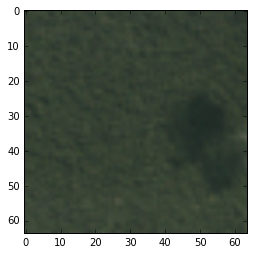

(64L, 64L, 3L)
[0 0 0 1]
()


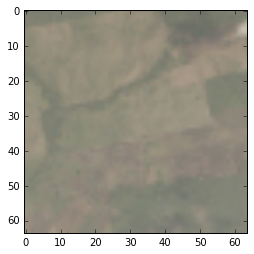

(64L, 64L, 3L)
[0 0 0 1]
()


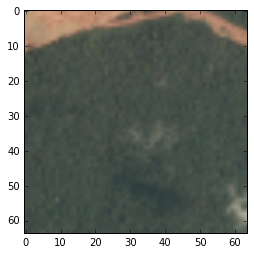

(64L, 64L, 3L)
[0 1 0 0]
()


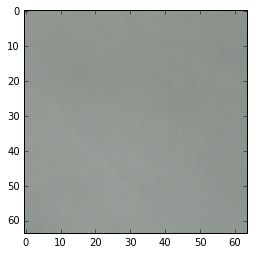

(64L, 64L, 3L)
[0 0 1 0]
()


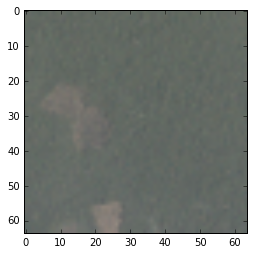

(64L, 64L, 3L)
[0 1 0 0]
()


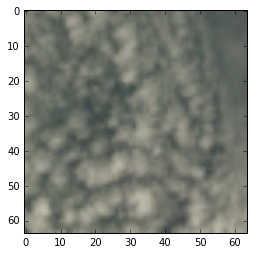

(64L, 64L, 3L)
[0 0 1 0]
()


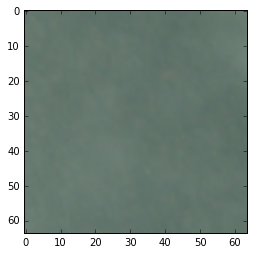

In [4]:
batch = train_gen.next()

for i in range(batch[0].shape[0]):
    img = batch[0][i,:,:,:]
    img = np.transpose(img, (1,2,0))
    print(img.shape)
    print(batch[1][i])
    print()
    plt.figure()
    plt.imshow(img)
    plt.show()

In [5]:
'''
model = Sequential()

model.add(BatchNormalization(input_shape=[3, 256, 256], axis=1))

model.add(Conv2D(32, 3, 3, input_shape=[3, 256, 256], activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(32, 3, 3, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(64, 3, 3, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(Conv2D(128, 3, 3, activation='relu'))
model.add(BatchNormalization(axis=1))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(weather_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy', 'categorical_crossentropy'])

model.summary()
'''

"\nmodel = Sequential()\n\nmodel.add(BatchNormalization(input_shape=[3, 256, 256], axis=1))\n\nmodel.add(Conv2D(32, 3, 3, input_shape=[3, 256, 256], activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(Conv2D(32, 3, 3, activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(64, 3, 3, activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(Conv2D(64, 3, 3, activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Conv2D(128, 3, 3, activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(Conv2D(128, 3, 3, activation='relu'))\nmodel.add(BatchNormalization(axis=1))\nmodel.add(MaxPooling2D(pool_size=(2, 2)))\n\nmodel.add(Flatten())\nmodel.add(Dense(512, activation='relu'))\nmodel.add(Dense(len(weather_labels), activation='softmax'))\n\nmodel.compile(loss='categorical_crossentropy',\n             optimizer=Adam(),\n            

In [6]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=[3, 64, 64]))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(len(weather_labels), activation='softmax'))

model.compile(loss='categorical_crossentropy',
             optimizer=Adam(),
             metrics=['accuracy', 'categorical_crossentropy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 62, 62)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 60, 60)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 30, 30)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               2880100   
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 404       
Total params: 2,890,648
Trainable params: 2,890,648
Non-trainable params: 0
_________________________________________________________________


In [7]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint(filepath='E:/KI/Master/MLIP/Brainforest/WeatherTest/model.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose=1, save_best_only=True)

model.fit_generator(train_gen, steps_per_epoch=len(train_data)/batch_size,
                    epochs=25, verbose=1,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, validation_steps=len(val_data))

#model.fit(X_train, y_train, validation_data=(X_val, y_val), nb_epoch=25, batch_size=8, verbose=1, callbacks=[csv_logger, lr_plateau, checkpoint])

Epoch 1/25
3541/3541 [==============================] - 438s - loss: 1.2790 - acc: 0.3949 - categorical_crossentropy: 1.2790 - val_loss: 1.2888 - val_acc: 0.4436 - val_categorical_crossentropy: 1.2888
Epoch 2/25
 316/3541 [=>............................] - ETA: 81s - loss: 1.1749 - acc: 0.4889 - categorical_crossentropy: 1.1749

KeyboardInterrupt: 

In [ ]:
'''
model.load_weights("../../WeatherTest/model.00-9.72.hdf5")
imgs, labels = next(val_gen)
prediction = model.predict(imgs)
for i in range(len(labels)):
    print(labels[i], prediction[i])
'''